1. Mounting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

2. Unzipping the zipped folder for training

In [20]:
import time
drive_zip_path = '/content/drive/MyDrive/Dataset/Brain Tumor MRI images.zip'

print("Copying data from Google Drive to local Colab runtime...")
start_time = time.time()
!cp '{drive_zip_path}' '/content/dataset.zip'

end_time = time.time()
print(f"Copying took {end_time - start_time:.2f} seconds.")

print("\nUnzipping data...")
!unzip -q /content/dataset.zip -d /content/dataset

print("Data is ready for local processing!")

Copying data from Google Drive to local Colab runtime...
Copying took 0.40 seconds.

Unzipping data...
Data is ready for local processing!


3. Import necessary libraries

In [21]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

4. Defining categories and image size

In [22]:
data_dir='/content/drive/MyDrive/Dataset/Brain Tumor MRI images'
categories=['Tumor','Healthy']
img_size=150

5. Creating Training Dtata by preprocessing it and then shuffling it.
  Splitting data into training and testing sets.

In [23]:
def create_training_data():
  training_data=[]
  for cat in categories:
    path=os.path.join(data_dir,cat)
    class_num=categories.index(cat)
    for img_name in os.listdir(path):
      try:
        img_path = os.path.join(path, img_name)
        img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        new_array = cv2.resize(img_array, (img_size, img_size))
        training_data.append([new_array, class_num])
      except Exception as e:
        pass
  return training_data
training_data = create_training_data()
print(f"Data loading complete! Found {len(training_data)} images.")


import random
random.shuffle(training_data)

X = [] # Features (images)
y = [] # Labels (tumor/healthy)

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).astype('float32') / 255.0
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Data loading complete! Found 5093 images.
Training data shape: (4074, 150, 150, 3)
Testing data shape: (1019, 150, 150, 3)


6. Building the model using transfer learning (VGG16)

In [24]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

7. Training the model

In [26]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_test, y_test)
)

model.save('brain_tumor_vgg16.h5')
print("Model saved as brain_tumor_vgg16.h5")

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - accuracy: 0.9876 - loss: 0.0291 - val_accuracy: 0.9863 - val_loss: 0.0436
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - accuracy: 0.9920 - loss: 0.0217 - val_accuracy: 0.9833 - val_loss: 0.0539
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 0.9918 - loss: 0.0248 - val_accuracy: 0.9882 - val_loss: 0.0385
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9952 - loss: 0.0179 - val_accuracy: 0.9843 - val_loss: 0.0532
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.9867 - loss: 0.0295 - val_accuracy: 0.9872 - val_loss: 0.0416
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9934 - loss: 0.0205 - val_accuracy: 0.9872 - val_loss: 0.0469
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 0.9908 - loss: 0.0238 - val_accuracy: 0.9863 - val_loss: 0.0440
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 0.9949 - loss: 0

Model saved as brain_tumor_vgg16.h5


8. Visualizing model performance

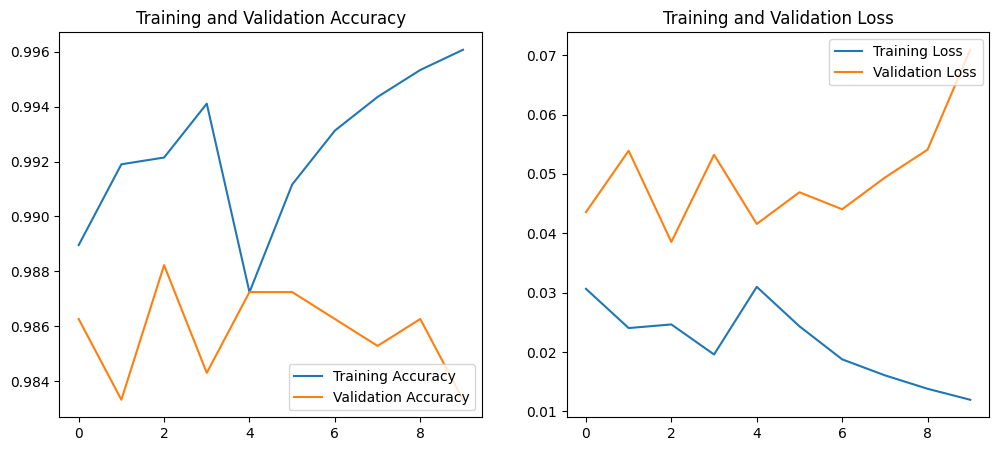

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(10)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()